In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load Dataset

In [2]:
twitch_df = pd.read_csv("twitch.csv", parse_dates=['Date'])
twitch = twitch_df.copy()
twitch.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language,Date
0,xQcOW,6196161750,215250,222720,27716,3246298,1734810,93036735,True,False,English,2014-09-12 23:50:00
1,summit1g,6091677300,211845,310998,25610,5310163,1370184,89705964,True,False,English,2011-12-01 06:33:00
2,Gaules,5644590915,515280,387315,10976,1767635,1023779,102611607,True,True,Portuguese,2017-11-09 14:10:00
3,ESL_CSGO,3970318140,517740,300575,7714,3944850,703986,106546942,True,False,English,2012-06-11 13:36:00
4,Tfue,3671000070,123660,285644,29602,8938903,2068424,78998587,True,False,English,2014-04-02 03:57:00


# Explore Dataset

In [3]:
twitch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Channel               1000 non-null   object        
 1   Watch time(Minutes)   1000 non-null   int64         
 2   Stream time(minutes)  1000 non-null   int64         
 3   Peak viewers          1000 non-null   int64         
 4   Average viewers       1000 non-null   int64         
 5   Followers             1000 non-null   int64         
 6   Followers gained      1000 non-null   int64         
 7   Views gained          1000 non-null   int64         
 8   Partnered             1000 non-null   bool          
 9   Mature                1000 non-null   bool          
 10  Language              1000 non-null   object        
 11  Date                  992 non-null    datetime64[ns]
dtypes: bool(2), datetime64[ns](1), int64(7), object(2)
memory usage: 80.2+ KB


In [4]:
twitch['Stream time(minutes)'].max()/60/24

362.1145833333333

In [5]:
twitch['Language'].value_counts()

English       485
Korean         77
Russian        74
Spanish        68
French         66
Portuguese     61
German         49
Chinese        30
Turkish        22
Italian        17
Polish         12
Thai           11
Japanese       10
Czech           6
Arabic          5
Hungarian       2
Swedish         1
Other           1
Slovak          1
Finnish         1
Greek           1
Name: Language, dtype: int64

# Preprocessing 

In [6]:
# Categorical Variables

In [7]:
twitch['English'] = twitch['Language'] == "English" # 1 if English otherwise 0
twitch['English'] = twitch['English'].astype('int')
twitch['Partnered'] = twitch['Partnered'].astype('int') # 1 if Partnered otherwise 0
twitch['Mature'] = twitch['Mature'].astype('int') # 1 if Mature otherwise 0

In [8]:
# Datetime

In [9]:
from datetime import datetime, timedelta

time = datetime(2020, 9, 1)

twitch['Date'] = time - twitch['Date']

twitch['Date'] = list(date.days for date in twitch['Date'])

In [10]:
# Null

In [11]:
twitch['Date'][twitch['Date'].isna()] = twitch['Date'].median()

In [12]:
# Desc

In [13]:
twitch['Desc'] = "original"

# EDA

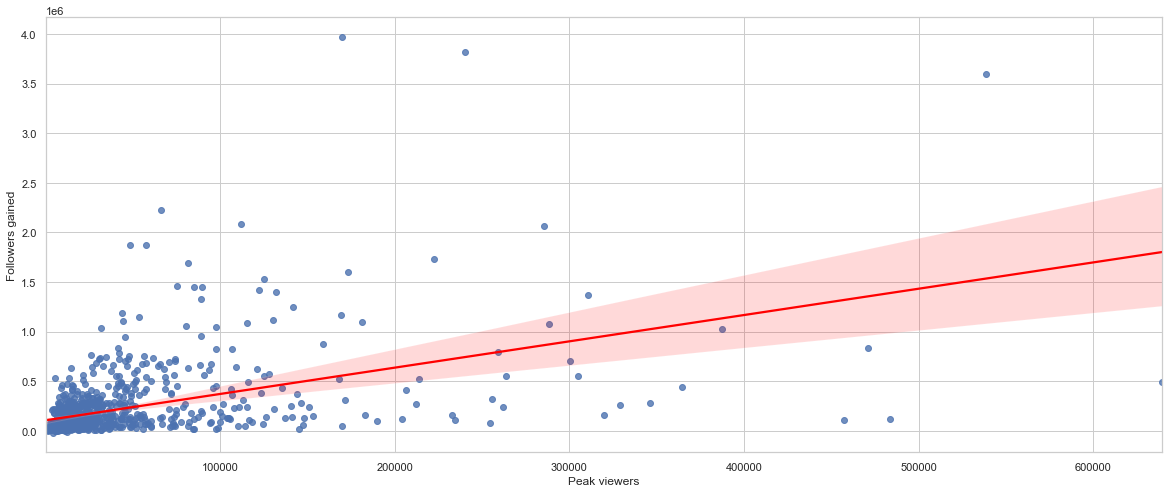

In [14]:
plt.figure(figsize=(20,8))
sns.set_style("whitegrid")
sns.regplot(x='Peak viewers', y='Followers gained', data=twitch, line_kws={"color": "red"});

In [15]:
twitch['Followers gained'].sort_values(ascending=False)

14     3966525
13     3820532
25     3593081
51     2220765
90     2085831
        ...   
758       1328
779        111
997      -4942
499      -5405
656     -15772
Name: Followers gained, Length: 1000, dtype: int64

In [16]:
# Outlier in Spanish Channels?
twitch.iloc[14], twitch.iloc[13], twitch.iloc[25]

(Channel                  auronplay
 Watch time(Minutes)     2410022550
 Stream time(minutes)         40575
 Peak viewers                170115
 Average viewers              53986
 Followers                  3983847
 Followers gained           3966525
 Views gained              41514854
 Partnered                        1
 Mature                           0
 Language                   Spanish
 Date                           363
 English                          0
 Desc                      original
 Name: 14, dtype: object,
 Channel                     Rubius
 Watch time(Minutes)     2588632635
 Stream time(minutes)         58275
 Peak viewers                240096
 Average viewers              42948
 Followers                  5751354
 Followers gained           3820532
 Views gained              58599449
 Partnered                        1
 Mature                           0
 Language                   Spanish
 Date                          2788
 English                          0
 D

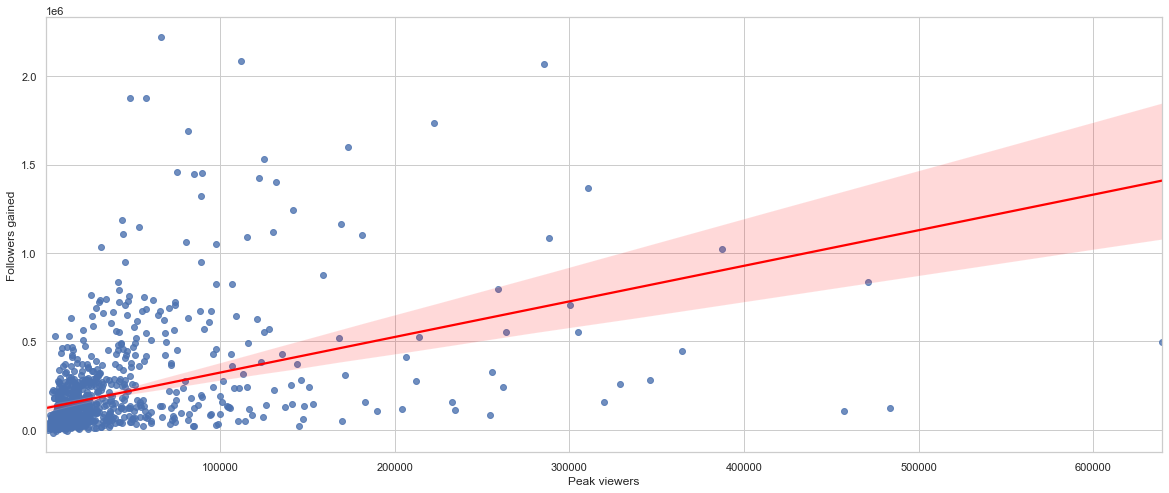

In [17]:
plt.figure(figsize=(20,8))
sns.set_style("whitegrid")
sns.regplot(x='Peak viewers', y='Followers gained', data=twitch.drop(index=[13,14,25]), line_kws={"color": "red"});

In [18]:
corr_matrix = twitch.corr()
corr_matrix

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Date,English
Watch time(Minutes),1.000000,0.150588,0.582797,0.476165,0.620234,0.514648,0.529862,0.038258,-0.043197,0.037790,0.094492
Stream time(minutes),0.150588,1.000000,-0.119540,-0.249248,-0.091299,-0.158165,0.064370,-0.007073,0.044978,-0.019371,0.045116
Peak viewers,0.582797,-0.119540,1.000000,0.682637,0.532529,0.470415,0.298063,0.028112,-0.082750,0.019987,0.073642
Average viewers,0.476165,-0.249248,0.682637,1.000000,0.428303,0.420097,0.250349,-0.008983,-0.081648,0.002039,0.038105
Followers,0.620234,-0.091299,0.532529,0.428303,1.000000,0.715618,0.276467,0.044418,-0.088521,0.122110,0.163707
Followers gained,0.514648,-0.158165,0.470415,0.420097,0.715618,1.000000,0.244297,0.027465,-0.093001,-0.103026,-0.006353
Views gained,0.529862,0.064370,0.298063,0.250349,0.276467,0.244297,1.000000,-0.035313,-0.088119,-0.025051,0.033871
Partnered,0.038258,-0.007073,0.028112,-0.008983,0.044418,0.027465,-0.035313,1.000000,0.000972,0.138880,0.022780
Mature,-0.043197,0.044978,-0.082750,-0.081648,-0.088521,-0.093001,-0.088119,0.000972,1.000000,0.072779,0.116251
Date,0.037790,-0.019371,0.019987,0.002039,0.122110,-0.103026,-0.025051,0.138880,0.072779,1.000000,0.213450


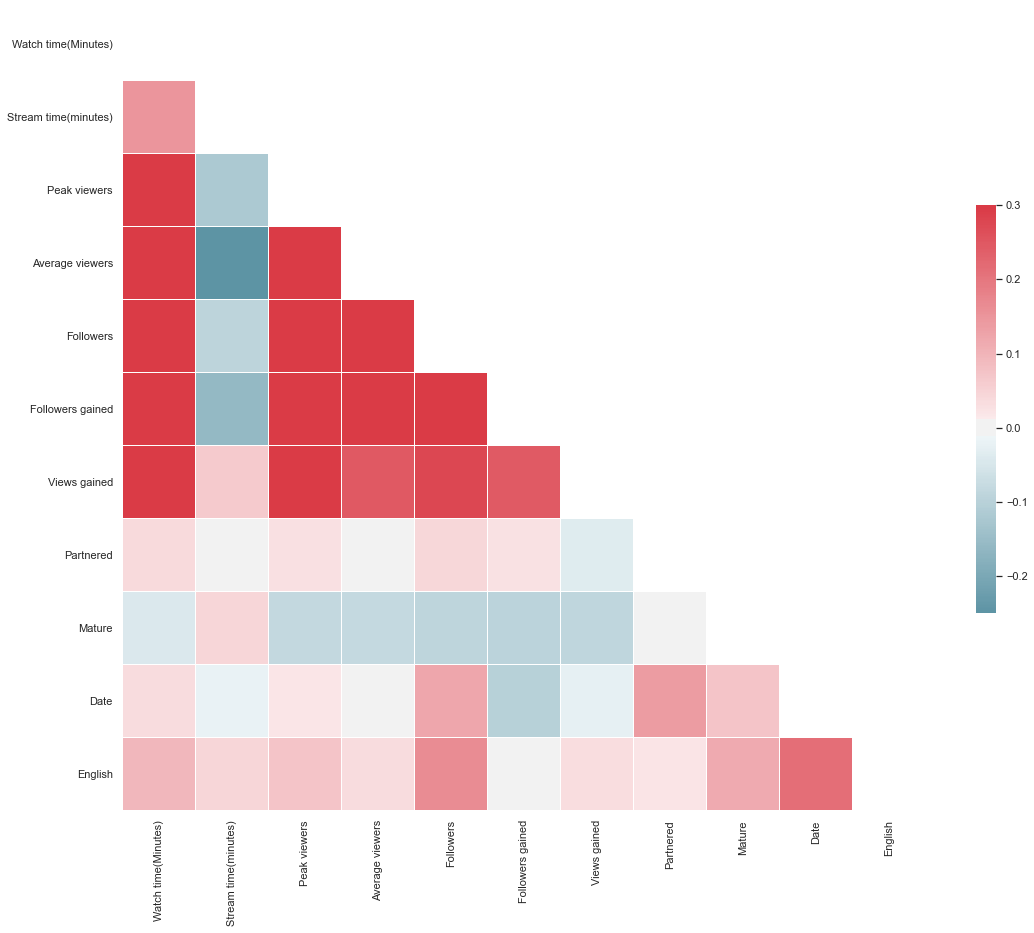

In [19]:
mask = np.zeros_like(twitch.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(twitch.corr(), mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

# Statsmodels

In [20]:
target = twitch['Followers gained']
feature = twitch.drop(columns = ['Channel','Language','Followers gained', 'Desc'])
feature = sm.add_constant(feature, has_constant='add')
scaler = StandardScaler()
scaler.fit(feature)
feature = pd.DataFrame(scaler.transform(feature), columns = feature.columns)
model = sm.OLS(target, feature).fit()
print(model.summary2())

                         Results: Ordinary least squares
Model:                    OLS              Adj. R-squared (uncentered): 0.419     
Dependent Variable:       Followers gained AIC:                         28087.9206
Date:                     2021-01-18 15:22 BIC:                         28136.9982
No. Observations:         1000             Log-Likelihood:              -14034.   
Df Model:                 10               F-statistic:                 73.23     
Df Residuals:             990              Prob (F-statistic):          7.89e-112 
R-squared (uncentered):   0.425            Scale:                       9.1545e+10
----------------------------------------------------------------------------------
                        Coef.     Std.Err.     t    P>|t|     [0.025      0.975]  
----------------------------------------------------------------------------------
const                     0.0000     0.0000     nan    nan      0.0000      0.0000
Watch time(Minutes)   36581.50

In [21]:
target = twitch['Followers gained']
feature = twitch.drop(columns = ['Channel','Language','Followers gained', 'Desc'])
feature = sm.add_constant(feature, has_constant='add')
scaler = MinMaxScaler()
scaler.fit(feature)
feature = pd.DataFrame(scaler.transform(feature), columns = feature.columns)
model = sm.OLS(target, feature).fit()
print(model.summary2())

                           Results: Ordinary least squares
Model:                    OLS                Adj. R-squared (uncentered):   0.685     
Dependent Variable:       Followers gained   AIC:                           27475.1407
Date:                     2021-01-18 15:22   BIC:                           27524.2183
No. Observations:         1000               Log-Likelihood:                -13728.   
Df Model:                 10                 F-statistic:                   218.9     
Df Residuals:             990                Prob (F-statistic):            9.96e-243 
R-squared (uncentered):   0.689              Scale:                         4.9603e+10
--------------------------------------------------------------------------------------
                        Coef.       Std.Err.     t    P>|t|     [0.025       0.975]   
--------------------------------------------------------------------------------------
const                      0.0000      0.0000     nan    nan       0.00

In [22]:
print(pd.DataFrame({
    "VIF Factor": [variance_inflation_factor(feature.values, idx) \
for idx in range(feature.shape[1])],
    "features": feature.columns,
}))

    VIF Factor              features
0          NaN                 const
1     3.433070   Watch time(Minutes)
2     3.339224  Stream time(minutes)
3     3.183817          Peak viewers
4     2.630979       Average viewers
5     2.826492             Followers
6     1.697766          Views gained
7     9.702163             Partnered
8     1.345336                Mature
9     7.646334                  Date
10    2.111597               English


# Drop Outlier

In [23]:
def get_outlier(df=None, column=None, weight=1.5):
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)
    
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = df[column][(df[column] < lowest_val) | (df[column] > highest_val)].index
    
    return outlier_index

In [24]:
outlier_index = get_outlier(df=twitch, column='Peak viewers', weight=1.5)
twitch_outlier = twitch.drop(outlier_index, axis=0)
twitch_outlier['Desc'] = 'Peak viewers outlier'
twitch_outlier.shape

(887, 14)

In [25]:
outlier_index = get_outlier(df=twitch, column='Followers gained', weight=1.5)
twitch_outlier_2 = twitch.drop(outlier_index, axis=0)
twitch_outlier_2['Desc'] = 'Followers gained outlier'
twitch_outlier_2.shape

(910, 14)

In [26]:
outlier_index = get_outlier(df=twitch, column='Stream time(minutes)', weight=1.5)
twitch_outlier_3 = twitch.drop(outlier_index, axis=0)
twitch_outlier_3['Desc'] = 'Stream time(minutes) outlier'
twitch_outlier_3.shape

(952, 14)

In [27]:
twitch_outlier_3.corr()

,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Date,English
Watch time(Minutes),1.000000,0.118693,0.550982,0.508734,0.632594,0.526070,0.505744,0.040295,-0.060091,0.053653,0.111763
Stream time(minutes),0.118693,1.000000,-0.266409,-0.328798,-0.116760,-0.204461,0.033251,0.093639,0.102635,0.102746,0.097040
Peak viewers,0.550982,-0.266409,1.000000,0.704940,0.524653,0.468662,0.265384,0.020467,-0.090472,0.014364,0.071668
Average viewers,0.508734,-0.328798,0.704940,1.000000,0.427200,0.415155,0.252351,-0.020086,-0.085599,-0.006248,0.038471
Followers,0.632594,-0.116760,0.524653,0.427200,1.000000,0.715297,0.261197,0.034185,-0.087124,0.113023,0.163555
Followers gained,0.526070,-0.204461,0.468662,0.415155,0.715297,1.000000,0.236171,0.019426,-0.100129,-0.113155,-0.004725
Views gained,0.505744,0.033251,0.265384,0.252351,0.261197,0.236171,1.000000,-0.050367,-0.091622,-0.024894,0.036427
Partnered,0.040295,0.093639,0.020467,-0.020086,0.034185,0.019426,-0.050367,1.000000,0.039230,0.124806,0.042499
Mature,-0.060091,0.102635,-0.090472,-0.085599,-0.087124,-0.100129,-0.091622,0.039230,1.000000,0.093627,0.132284
Date,0.053653,0.102746,0.014364,-0.006248,0.113023,-0.113155,-0.024894,0.124806,0.093627,1.000000,0.209412


In [28]:
outlier_index = get_outlier(df=twitch, column='Average viewers', weight=1.5)
twitch_outlier_4 = twitch.drop(outlier_index, axis=0)
twitch_outlier_4['Desc'] = 'Average viewers outlier'
twitch_outlier_4.shape

(900, 14)

In [29]:
outlier_index_1 = get_outlier(df=twitch, column='Peak viewers', weight=1.5)
outlier_index_2 = get_outlier(df=twitch, column='Average viewers', weight=1.5)
outlier_index_3 = list(set(list(outlier_index_2)+list(outlier_index_1)))
twitch_outlier_5 = twitch.drop(outlier_index_3, axis=0)
twitch_outlier_5['Desc'] = 'Average viewers & Peak viewers outlier'
twitch_outlier_5.shape

(850, 14)

In [30]:
outlier_index_4 = get_outlier(df=twitch, column='Followers gained', weight=1.5)
outlier_index_5 = get_outlier(df=twitch, column='Stream time(minutes)', weight=1.5)
outlier_index_6 = list(set(list(outlier_index_4)+list(outlier_index_5)))
twitch_outlier_6 = twitch.drop(outlier_index_6, axis=0)
twitch_outlier_6['Desc'] = 'Followers gained & Stream time(minutes)'
twitch_outlier_6.shape

(864, 14)

# Drop 24hr Channels

In [31]:
twitch_str_time = twitch.sort_values(by = "Stream time(minutes)", ascending=False)
twitch_str_time.reset_index(inplace=True, drop=True)
twitch_str_time['Desc'] = '24hr channels'
twitch_str_time.head()

,Channel,Watch time(Minutes),Stream time(minutes),Peak viewers,Average viewers,Followers,Followers gained,Views gained,Partnered,Mature,Language,Date,English,Desc
0,RiffTrax,293583075,521445,24765,562,79099,17200,3313465,1,0,English,4030.0,1,24hr channels
1,RelaxBeats,123273930,521430,2830,235,166162,29595,1094850,1,0,English,1230.0,1,24hr channels
2,Monstercat,163589370,519675,14261,313,788684,22331,4084222,1,0,English,3151.0,1,24hr channels
3,RocketBeansTV,360858030,518415,5223,696,416018,27024,5973152,1,0,German,2573.0,0,24hr channels
4,SaltyTeemo,247613265,517980,1803,476,173196,36103,2117741,0,0,English,2498.0,1,24hr channels


In [32]:
index = [x for x in list(range(30)) if x not in [7,11,13,15,17,21,27,28]]
twitch_cln = twitch_str_time.drop(index=index)
twitch_cln = twitch_cln.sort_values(by="Watch time(Minutes)", ascending=False)

# Linear Regression

In [33]:
# All Variables

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor


X = twitch.drop(columns=['Channel','Language','Followers gained', 'Desc'])
y = twitch['Followers gained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

estimators = [('scaler', StandardScaler()),
             ('clf', LinearRegression())]

pipe = Pipeline(estimators)

pipe.fit(X_train, y_train)

y_pred_tr = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

rmse_tr = (np.sqrt(mean_squared_error(y_train, y_pred_tr)))
rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_test)))

lin_mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print('Train rmse : ', rmse_tr)
print('Test rmse : ', rmse_test)
print('Test mae : ', lin_mae)
print('Test r2 : ', r2)

Train rmse :  229207.65080204472
Test rmse :  183302.74023600895
Test mae :  113639.77413584932
Test r2 :  0.4860754096780424


# Function

In [35]:
df_2 = []

def lin_regr(data, drop_cols=[[], ['Date'], ['English'], ['Partnered'], ['Date','English','Partnered']]):

    df = []

    for column in drop_cols:
        X = data.drop(columns = ['Channel','Language','Desc', 'Followers gained'] + column)
        y = data['Followers gained']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
        
        rgr_list = [LinearRegression(), ElasticNet(alpha=0.1, l1_ratio=0.5), SVR(kernel='poly', degree=2, C=100, epsilon=0.1), 
                    RandomForestRegressor(max_depth=2, random_state=10)]
        scaler_list = [StandardScaler(), MinMaxScaler()]
        
        for rgr in rgr_list:

            for  scaler in scaler_list:
            
                estimators = [('scaler', scaler),
                             ('rgr', rgr)]

                pipe = Pipeline(estimators)

                pipe.fit(X_train, y_train)

                y_pred_tr = pipe.predict(X_train)
                y_pred_test = pipe.predict(X_test)

    #             rmse_tr = (np.sqrt(mean_squared_error(y_train, y_pred_tr)))
                rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
                lin_mae = mean_absolute_error(y_test, y_pred_test)
                r2 = r2_score(y_test, y_pred_test)
                mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

                df.append({'Dataset' : data.iloc[0]['Desc'], 'Drop Columns' : ', '.join(column), 'scaler' : scaler, 
                           'rgr' : rgr, 'RMSE' : int(round(rmse_test)), 'MAE' : int(round(lin_mae)), 
                           'MAPE' : int(round(mape)), 'R2_Score' : round(r2, 5)})
    df_2.extend(df)
    df = pd.DataFrame(df)
    return df.sort_values(by='R2_Score', ascending=False).head()

# Test Models

In [36]:
# 1. raw dataset
lin_regr(twitch)

,Dataset,Drop Columns,scaler,rgr,RMSE,MAE,MAPE,R2_Score
26,original,Partnered,StandardScaler(),ElasticNet(alpha=0.1),181016,111630,138,0.49882
2,original,,StandardScaler(),ElasticNet(alpha=0.1),181818,111823,139,0.49437
24,original,Partnered,StandardScaler(),LinearRegression(),182517,113405,142,0.49047
25,original,Partnered,MinMaxScaler(),LinearRegression(),182517,113405,142,0.49047
0,original,,StandardScaler(),LinearRegression(),183303,113640,143,0.48608


In [37]:
# 2. drop 24hour channels dataset
lin_regr(twitch_cln)

,Dataset,Drop Columns,scaler,rgr,RMSE,MAE,MAPE,R2_Score
26,24hr channels,Partnered,StandardScaler(),ElasticNet(alpha=0.1),241345,124490,149,0.54969
24,24hr channels,Partnered,StandardScaler(),LinearRegression(),242353,127488,152,0.54592
25,24hr channels,Partnered,MinMaxScaler(),LinearRegression(),242353,127488,152,0.54592
2,24hr channels,,StandardScaler(),ElasticNet(alpha=0.1),242853,125566,151,0.54405
1,24hr channels,,MinMaxScaler(),LinearRegression(),243049,128681,155,0.54331


In [38]:
# drop peak viewers outlier
lin_regr(twitch_outlier)

,Dataset,Drop Columns,scaler,rgr,RMSE,MAE,MAPE,R2_Score
25,Peak viewers outlier,Partnered,MinMaxScaler(),LinearRegression(),146830,91662,114,0.49185
24,Peak viewers outlier,Partnered,StandardScaler(),LinearRegression(),146830,91662,114,0.49185
26,Peak viewers outlier,Partnered,StandardScaler(),ElasticNet(alpha=0.1),148425,91674,112,0.48075
0,Peak viewers outlier,,StandardScaler(),LinearRegression(),150971,93589,117,0.46278
1,Peak viewers outlier,,MinMaxScaler(),LinearRegression(),150971,93589,117,0.46278


In [39]:
# drop follower gained outlier (Best RMSE, MAE)
lin_regr(twitch_outlier_2) 

,Dataset,Drop Columns,scaler,rgr,RMSE,MAE,MAPE,R2_Score
31,Followers gained outlier,Partnered,MinMaxScaler(),"(DecisionTreeRegressor(max_depth=2, max_featur...",77355,57758,135,0.37969
30,Followers gained outlier,Partnered,StandardScaler(),"(DecisionTreeRegressor(max_depth=2, max_featur...",77355,57758,135,0.37969
6,Followers gained outlier,,StandardScaler(),"(DecisionTreeRegressor(max_depth=2, max_featur...",77355,57758,135,0.37969
7,Followers gained outlier,,MinMaxScaler(),"(DecisionTreeRegressor(max_depth=2, max_featur...",77355,57758,135,0.37969
23,Followers gained outlier,English,MinMaxScaler(),"(DecisionTreeRegressor(max_depth=2, max_featur...",77355,57758,135,0.37969


In [40]:
# drop stream time outlier (Best R2 Score)
lin_regr(twitch_outlier_3)

,Dataset,Drop Columns,scaler,rgr,RMSE,MAE,MAPE,R2_Score
25,Stream time(minutes) outlier,Partnered,MinMaxScaler(),LinearRegression(),211824,115947,150,0.67756
24,Stream time(minutes) outlier,Partnered,StandardScaler(),LinearRegression(),211824,115947,150,0.67756
1,Stream time(minutes) outlier,,MinMaxScaler(),LinearRegression(),212246,117110,153,0.67628
0,Stream time(minutes) outlier,,StandardScaler(),LinearRegression(),212246,117110,153,0.67628
26,Stream time(minutes) outlier,Partnered,StandardScaler(),ElasticNet(alpha=0.1),213634,115775,152,0.67203


In [41]:
# drop average viewers outlier
lin_regr(twitch_outlier_4)

,Dataset,Drop Columns,scaler,rgr,RMSE,MAE,MAPE,R2_Score
26,Average viewers outlier,Partnered,StandardScaler(),ElasticNet(alpha=0.1),143723,87176,149,0.55463
18,Average viewers outlier,English,StandardScaler(),ElasticNet(alpha=0.1),144106,87021,142,0.55225
2,Average viewers outlier,,StandardScaler(),ElasticNet(alpha=0.1),144556,87569,149,0.54945
34,Average viewers outlier,"Date, English, Partnered",StandardScaler(),ElasticNet(alpha=0.1),144974,87461,138,0.54684
25,Average viewers outlier,Partnered,MinMaxScaler(),LinearRegression(),146114,87691,149,0.53968


In [42]:
# drop average viewers & peak viewers outlier
lin_regr(twitch_outlier_5)

,Dataset,Drop Columns,scaler,rgr,RMSE,MAE,MAPE,R2_Score
25,Average viewers & Peak viewers outlier,Partnered,MinMaxScaler(),LinearRegression(),106073,75400,148,0.54936
24,Average viewers & Peak viewers outlier,Partnered,StandardScaler(),LinearRegression(),106073,75400,148,0.54936
26,Average viewers & Peak viewers outlier,Partnered,StandardScaler(),ElasticNet(alpha=0.1),106140,75100,143,0.54879
1,Average viewers & Peak viewers outlier,,MinMaxScaler(),LinearRegression(),106146,75479,149,0.54874
0,Average viewers & Peak viewers outlier,,StandardScaler(),LinearRegression(),106146,75479,149,0.54874


In [43]:
# drop Followers gained & Stream time(minutes) (combine 2 good score dataset but bad score)
lin_regr(twitch_outlier_6)

,Dataset,Drop Columns,scaler,rgr,RMSE,MAE,MAPE,R2_Score
31,Followers gained & Stream time(minutes),Partnered,MinMaxScaler(),"(DecisionTreeRegressor(max_depth=2, max_featur...",95395,73032,150,0.32209
30,Followers gained & Stream time(minutes),Partnered,StandardScaler(),"(DecisionTreeRegressor(max_depth=2, max_featur...",95395,73032,150,0.32209
6,Followers gained & Stream time(minutes),,StandardScaler(),"(DecisionTreeRegressor(max_depth=2, max_featur...",95395,73032,150,0.32209
7,Followers gained & Stream time(minutes),,MinMaxScaler(),"(DecisionTreeRegressor(max_depth=2, max_featur...",95395,73032,150,0.32209
23,Followers gained & Stream time(minutes),English,MinMaxScaler(),"(DecisionTreeRegressor(max_depth=2, max_featur...",95456,73069,150,0.32122


# Compare Models

In [44]:
table_df = pd.DataFrame(df_2)
table_df.rgr = table_df.rgr.astype('str')
table_df.scaler = table_df.scaler.astype('str')

In [45]:
table_df

,Dataset,Drop Columns,scaler,rgr,RMSE,MAE,MAPE,R2_Score
0,original,,StandardScaler(),LinearRegression(),183303,113640,143,0.48608
1,original,,MinMaxScaler(),LinearRegression(),183303,113640,143,0.48608
2,original,,StandardScaler(),ElasticNet(alpha=0.1),181818,111823,139,0.49437
3,original,,MinMaxScaler(),ElasticNet(alpha=0.1),215160,146245,244,0.29191
4,original,,StandardScaler(),"SVR(C=100, degree=2, kernel='poly')",266407,146603,144,-0.08556
...,...,...,...,...,...,...,...,...
315,Followers gained & Stream time(minutes),"Date, English, Partnered",MinMaxScaler(),ElasticNet(alpha=0.1),107946,87578,206,0.13198
316,Followers gained & Stream time(minutes),"Date, English, Partnered",StandardScaler(),"SVR(C=100, degree=2, kernel='poly')",121590,88963,155,-0.10133
317,Followers gained & Stream time(minutes),"Date, English, Partnered",MinMaxScaler(),"SVR(C=100, degree=2, kernel='poly')",118768,88216,159,-0.05080
318,Followers gained & Stream time(minutes),"Date, English, Partnered",StandardScaler(),"RandomForestRegressor(max_depth=2, random_stat...",99094,75444,153,0.26850


In [46]:
# sort by RMSE
table_df.sort_values(by='RMSE').head(10)

,Dataset,Drop Columns,scaler,rgr,RMSE,MAE,MAPE,R2_Score
126,Followers gained outlier,,StandardScaler(),"RandomForestRegressor(max_depth=2, random_stat...",77355,57758,135,0.37969
127,Followers gained outlier,,MinMaxScaler(),"RandomForestRegressor(max_depth=2, random_stat...",77355,57758,135,0.37969
151,Followers gained outlier,Partnered,MinMaxScaler(),"RandomForestRegressor(max_depth=2, random_stat...",77355,57758,135,0.37969
150,Followers gained outlier,Partnered,StandardScaler(),"RandomForestRegressor(max_depth=2, random_stat...",77355,57758,135,0.37969
142,Followers gained outlier,English,StandardScaler(),"RandomForestRegressor(max_depth=2, random_stat...",77355,57758,135,0.37969
143,Followers gained outlier,English,MinMaxScaler(),"RandomForestRegressor(max_depth=2, random_stat...",77355,57758,135,0.37969
138,Followers gained outlier,English,StandardScaler(),ElasticNet(alpha=0.1),77934,60148,130,0.37037
122,Followers gained outlier,,StandardScaler(),ElasticNet(alpha=0.1),77978,60835,127,0.36966
146,Followers gained outlier,Partnered,StandardScaler(),ElasticNet(alpha=0.1),78317,60686,126,0.36416
136,Followers gained outlier,English,StandardScaler(),LinearRegression(),78466,60041,130,0.36175


In [47]:
# sort by MAE
table_df.sort_values(by='MAE').head(10)

,Dataset,Drop Columns,scaler,rgr,RMSE,MAE,MAPE,R2_Score
142,Followers gained outlier,English,StandardScaler(),"RandomForestRegressor(max_depth=2, random_stat...",77355,57758,135,0.37969
126,Followers gained outlier,,StandardScaler(),"RandomForestRegressor(max_depth=2, random_stat...",77355,57758,135,0.37969
127,Followers gained outlier,,MinMaxScaler(),"RandomForestRegressor(max_depth=2, random_stat...",77355,57758,135,0.37969
150,Followers gained outlier,Partnered,StandardScaler(),"RandomForestRegressor(max_depth=2, random_stat...",77355,57758,135,0.37969
143,Followers gained outlier,English,MinMaxScaler(),"RandomForestRegressor(max_depth=2, random_stat...",77355,57758,135,0.37969
151,Followers gained outlier,Partnered,MinMaxScaler(),"RandomForestRegressor(max_depth=2, random_stat...",77355,57758,135,0.37969
159,Followers gained outlier,"Date, English, Partnered",MinMaxScaler(),"RandomForestRegressor(max_depth=2, random_stat...",79062,58601,138,0.35201
135,Followers gained outlier,Date,MinMaxScaler(),"RandomForestRegressor(max_depth=2, random_stat...",79062,58601,138,0.35201
134,Followers gained outlier,Date,StandardScaler(),"RandomForestRegressor(max_depth=2, random_stat...",79062,58601,138,0.35201
158,Followers gained outlier,"Date, English, Partnered",StandardScaler(),"RandomForestRegressor(max_depth=2, random_stat...",79062,58601,138,0.35201


In [48]:
# sort by R2_Score
table_df.sort_values(by='R2_Score', ascending=False).head(20)

,Dataset,Drop Columns,scaler,rgr,RMSE,MAE,MAPE,R2_Score
184,Stream time(minutes) outlier,Partnered,StandardScaler(),LinearRegression(),211824,115947,150,0.67756
185,Stream time(minutes) outlier,Partnered,MinMaxScaler(),LinearRegression(),211824,115947,150,0.67756
160,Stream time(minutes) outlier,,StandardScaler(),LinearRegression(),212246,117110,153,0.67628
161,Stream time(minutes) outlier,,MinMaxScaler(),LinearRegression(),212246,117110,153,0.67628
186,Stream time(minutes) outlier,Partnered,StandardScaler(),ElasticNet(alpha=0.1),213634,115775,152,0.67203
168,Stream time(minutes) outlier,Date,StandardScaler(),LinearRegression(),213859,119827,182,0.67134
169,Stream time(minutes) outlier,Date,MinMaxScaler(),LinearRegression(),213859,119827,182,0.67134
162,Stream time(minutes) outlier,,StandardScaler(),ElasticNet(alpha=0.1),214000,116820,154,0.67091
177,Stream time(minutes) outlier,English,MinMaxScaler(),LinearRegression(),214954,115201,155,0.66796
176,Stream time(minutes) outlier,English,StandardScaler(),LinearRegression(),214954,115201,155,0.66796


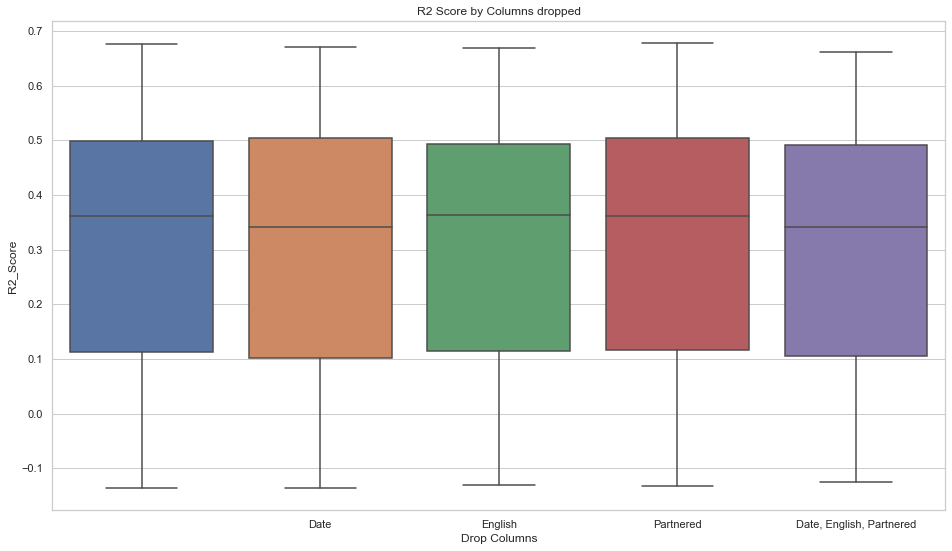

In [49]:
# Dropping columns doesn't make performance better
plt.figure(figsize=(16,9))
sns.set_style("whitegrid")
sns.boxplot(x='Drop Columns',y='R2_Score',data=table_df).set_title("R2 Score by Columns dropped");

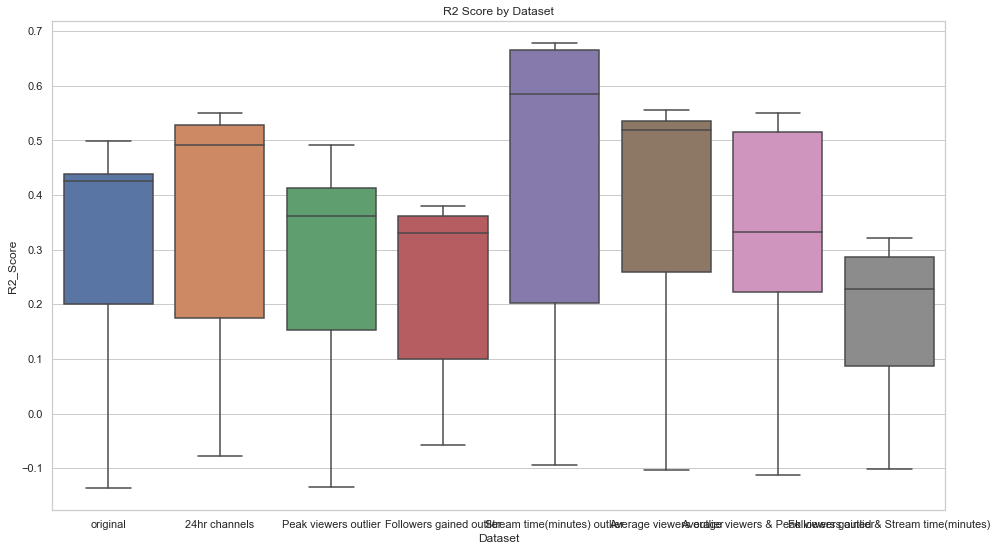

In [50]:
# Dropping Stream time outlier makes performance better
plt.figure(figsize=(16,9))
sns.boxplot(x='Dataset',y='R2_Score',data=table_df).set_title("R2 Score by Dataset");

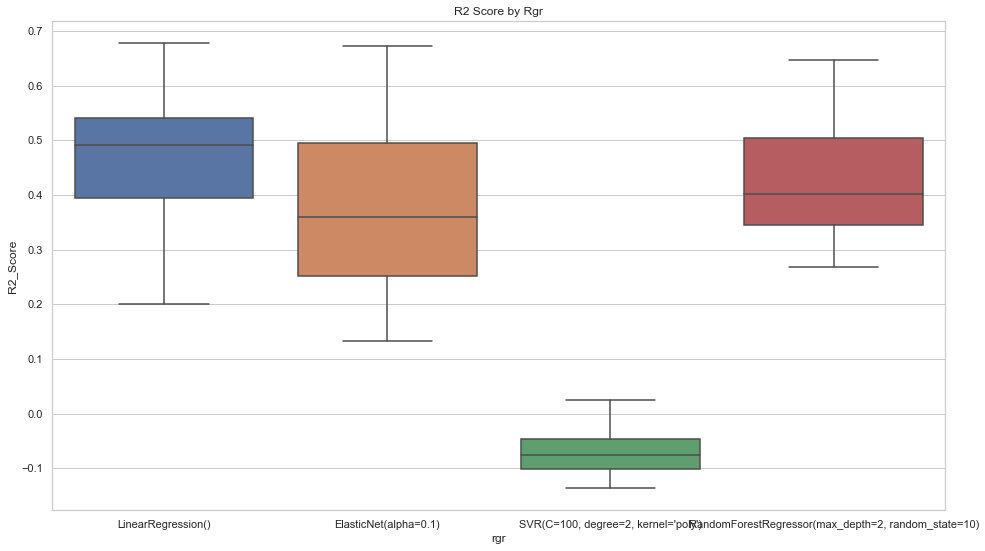

In [51]:
# LinearRegression was the best regressor for our dataset
plt.figure(figsize=(16,9))
sns.boxplot(x='rgr',y='R2_Score',data=table_df).set_title("R2 Score by Rgr");

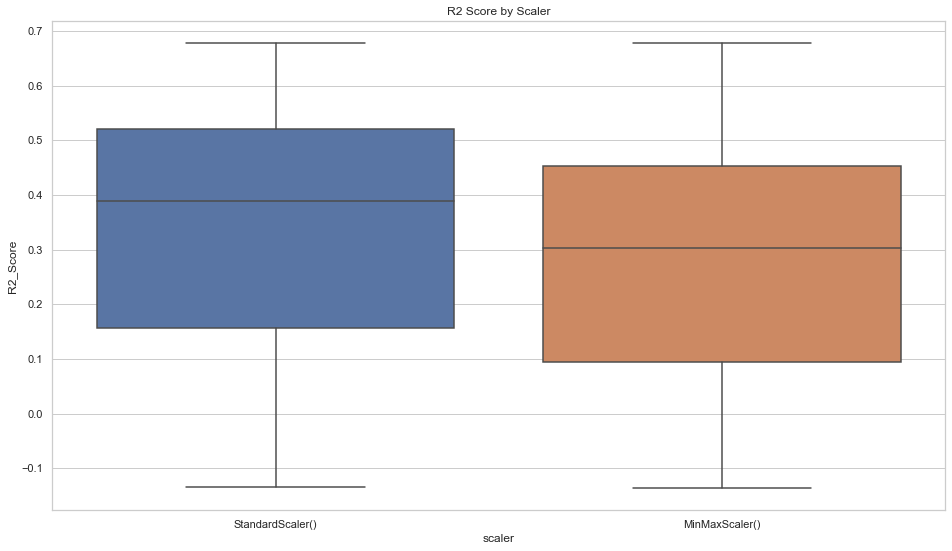

In [52]:
# StandardScaler was the better scaler for our dataset
plt.figure(figsize=(16,9))
sns.boxplot(x='scaler',y='R2_Score',data=table_df).set_title("R2 Score by Scaler");

# Predict

In [53]:
def predict_followers_gained(channel):
    X = twitch_outlier_3.drop(columns = ['Channel','Language','Desc', 'Followers gained', 'Partnered'])
    y = twitch_outlier_3['Followers gained']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

    estimators = [('scaler', StandardScaler()),
             ('rgr', LinearRegression())]

    pipe = Pipeline(estimators)

    pipe.fit(X_train, y_train)

    result = int(round(pipe.predict(channel)[0]))
    
    return result

In [54]:
# Real Followers gained : 179,851 Predict Followers gained : 182,147
# In fact, there are too many external variables that affects prediction.
# But prediction for this channel was pretty good :)
dhtekkz = [[59378100,21180,18364,2821,179851,1626543,0,1235,1]]
predict_followers_gained(dhtekkz)

182147

# Tuning Parameters

In [55]:
# Tuning max_depth and dropping Date column makes the best performance
X = twitch_outlier_3.drop(columns = ['Channel','Language','Desc', 'Followers gained', 'Date'])
y = twitch_outlier_3['Followers gained']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

estimators = [('scaler', StandardScaler()),
     ('rgr', RandomForestRegressor(max_depth=4, random_state=10))]

pipe = Pipeline(estimators)

pipe.fit(X_train, y_train)

y_pred_test = pipe.predict(X_test)

rmse_test = (np.sqrt(mean_squared_error(y_test, y_pred_test)))
lin_mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

print('RMSE : {}'.format(int(round(rmse_test))), 'MAE : {}'.format(int(round(lin_mae))),
      'MAPE : {}'.format(int(round(mape))), 'R2_Score : {}'.format(round(r2, 5)))

RMSE : 200823 MAE : 111958 MAPE : 172 R2_Score : 0.71019
